# Genre Recognition and Music Analysis

Goal: predict music genre from an .mp3 file 
    * accuracy > 2x better than random classification

Data Formatting and Cleaning:
    * load data into Utils
    * check equality of relation tables
    * use key(track_id) to apply operations on relation tables tracks, features, genres and echonest
    * drop unimportant columns

Exploratory Data Analysis:
    * vizualize distribution of track genres (histogram, pair plots)
    * vizualize clustering of genres
    * visualize correlations between features with heat maps
    * PCA decomposition
        * visualize loss of variance
        
Test and Train (Classifiers):
    * $k$-Nearest Neighbors
    * Decision Trees
    * Random Forest
    * Support Vector Machines

Optimization and Parameter Tuning 
    * $k$-Nearest Neighbors: optimize k & weight
    * Decision Trees & Random Forest: optimize max depth
    * Support Vector Machines: opt(penalty c) with linear and poly kernels

Model Analysis
    * compare classifiers with accuracy
    * evaluate performance

## Free Music Archieves (FMA) : A Dataset For Music Analysis

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.


FMA is an open dataset used for music analysis and genre recognition.  There are 4 .csv files in the dataset, tracks, genres, features and echonest.

* `tracks.csv`: per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks.
* `genres.csv`: all 163 genre IDs with their name and parent (used to infer the genre hierarchy and top-level genres).
* `features.csv`: common features extracted with librosa.
* `echonest.csv`: audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks.


We will not be using the genres.csv dataset for this project. The dataset is used for genre hierarchies. Only tracks, features and echonest will be used in the data/music analysis. And for the machine learning only tracks and the audio features of features will be used.


Paper:
https://arxiv.org/abs/1612.01840


Github:
https://github.com/mdeff/fma

@inproceedings{fma_dataset,
  title = {FMA: A Dataset for Music Analysis},
  author = {Defferrard, Micha\"el and Benzi, Kirell and Vandergheynst, Pierre and Bresson, Xavier},
  booktitle = {18th International Society for Music Information Retrieval Conference},
  year = {2017},
  url = {https://arxiv.org/abs/1612.01840},
}

# Data Collection


Download mp3s:
* `curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip`

verify integrity with checksum:
* `echo "ade154f733639d52e35e32f5593efe5be76c6d70  fma_small.zip"    | sha1sum -c -`
    
unzip:
* `unzip fma_small.zip`

checkout <a href="https://github.com/mdeff/fma/issues/9">'rc1'</a> version:  
* `git checkout rc1`

install packages and dependencies:
* `make install`

store path to audio directory in environment variable:
* `AUDIO_DIR=/fma_small/`

<a href="https://github.com/mdeff/fma/issues/34">The Utils.py file will need a couple changes due to the newest version of pandas</a>:
* insert at line 8
`from pandas.api.types import CategoricalDtype`

* replace line 217 `category', categories=SUBSETS, ordered=True)`


with `CategoricalDtype(categories=SUBSETS, ordered=True))`

In [1]:
import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import numpy as np
import pandas as pd

import utils


plt.rcParams['figure.figsize'] = (17, 5)

## Data Formatting and Cleaning 

Much of the data has been cleaned and formatted using Utils.py. The collectors of the dataset implemented  Utils.py as a pandas dataframe.  The data can be <a href="https://github.com/mdeff/fma/issues/34">loaded</a> directly from .csv files into this data structure.


There exist a key for each .csv file. This key, track_id, allows for operations between the 4 relation tables, tracks, genres, features and echonest. Because track_id is pivotal to using the dataset it is import to assert equallity of features and tracks before manipulating any data.

In [2]:
# Directory where mp3 are stored.
try:
    AUDIO_DIR = os.environ.get('AUDIO_DIR')
except KeyError:
    print("Environment variable does not exist:") 
    os.system('AUDIO_DIR=/fma_small/')

# Load metadata and features
tracks = utils.load('tracks.csv')
# genres = utils.load('genres.csv')
features = utils.load('features.csv')
echonest = utils.load('echonest.csv')

# check integrity 
np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

## Features

features is a collection of 518 common features extracted from librosa for each track. This is the set of metrics that determine what genre the audio is classified as. One of the most important features of the data set is the Mel-frequency cepstrum. This feature is also commonly used in audio compression and speech recognition.

In [3]:
feature_names = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast', 
          ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'],
          ['rmse', 'zcr']]
features.shape

(106574, 518)

The distribution of the features is somewhat normal. Since almost all of the features are coeffiecents the histograms does not show a large spread.

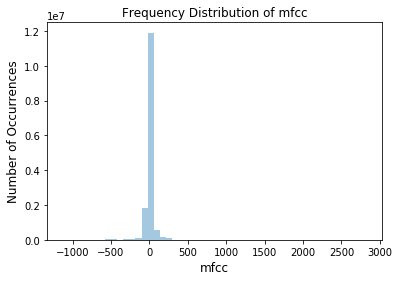

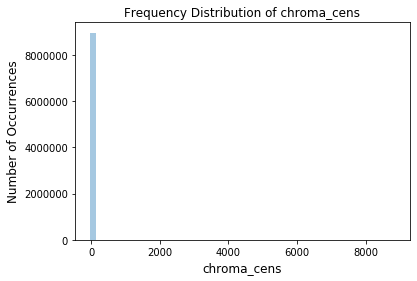

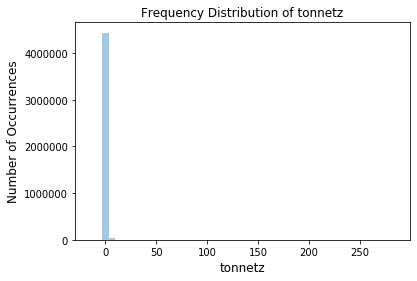

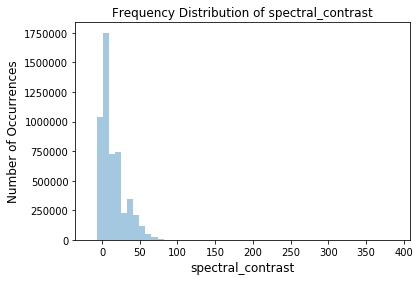

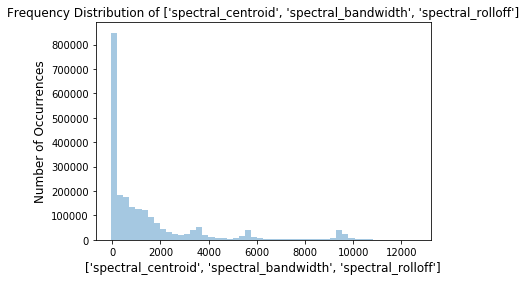

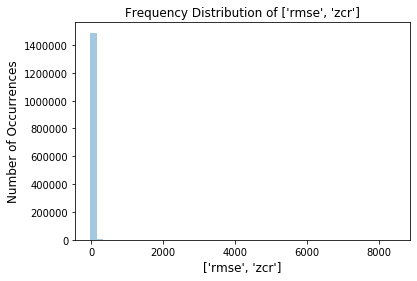

In [4]:
for name in feature_names:
    values = [val for val in features[name].values]
    sns.distplot(values, kde=False)
    plt.title('Frequency Distribution of ' + str(name))
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(name , fontsize=12)
    plt.show()

## tracks

Tracks contains metadata on for albums, artist and tracks. The key for tracks is the same as the other dataframes, track_id. 


In total there are 52 features. Not all of these features are necessary. Al columns that are needed are (track, track_id), (track, genre_tops) and ('sets',*). Every other column can be dropped.

In [5]:
tracks.head()

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

Removing instances from one table jeopardizes the integrity of all other relation tables we decided to train with without cleaning this table. We tried removing the unused coloumns and 'nan' values in tracks. 

In [6]:
# new list of track names
# track_names = [('track', 'genre_top'), ('set', 'split'), ('set', 'subset')]

# names of dropped features
# drop_names = [i for i in list(tracks.columns) if i not in track_names] 

# drop names and nan values
# tracks = tracks.drop(drop_names, axis=1).dropna()

# tracks.head()

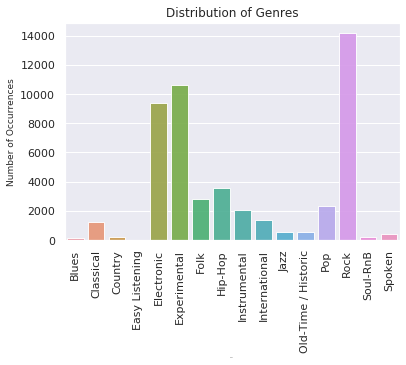

In [7]:
# plot distribution with a bar chart
count = tracks[('track', 'genre_top')].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Distribution of Genres')
plt.xticks(rotation='vertical')
plt.xlabel("Genres", fontsize=1)
plt.ylabel('Number of Occurrences', fontsize=9)
plt.show()

In [8]:
sets = ["training", "testing", "validation"]

for s in sets:
    count = (tracks[("set", 'split')] == s).value_counts(sort=False)
    print(count)

False    22221
True     84353
Name: (set, split), dtype: int64
False    106574
Name: (set, split), dtype: int64
False    95616
True     10958
Name: (set, split), dtype: int64


## echonest 

echonest contains metadata about each track. The dataframe is split into 4 different subsets, 'metadata', 'audio_features', 'social_features' and 'ranks'. This dataframe will not be used in the training or testing just visualization. There are many intersting features in this dataframe.

In [9]:
echonest['echonest', 'metadata'].head()
echonest['echonest', 'audio_features'].head()
echonest['echonest', 'social_features'].head()
echonest['echonest', 'ranks'].head()

print('{1} features for {0} tracks'.format(*echonest.shape))

249 features for 13129 tracks


# Data Analysis

# Comparing Clustering of Two Genres

We can visualize the clustering of each genre with a scatter plot. If we choose two genres we can see how similar the audio features are within the genres.

In [10]:
genre_names = tracks['track', 'genre_top'].values.unique().dropna()
for genre in genre_names:
    print(genre)

Hip-Hop
Pop
Rock
Experimental
Folk
Jazz
Electronic
Spoken
International
Soul-RnB
Blues
Country
Classical
Old-Time / Historic
Instrumental
Easy Listening


Input two of the listed genres above to visualize how similar the genres are with respect to their mfcc value.

In [11]:
valid = False

while not valid:
    genre1 = input("Enter first genre: ")
    genre2 = input("Enter second genre: ")
    if genre1 not in genre_names or genre2 not in genre_names: 
        print("That is not a genre. Try again:")
    else:
        valid = True

Enter first genre: Jazz
Enter second genre: Blues


To plot the two genres let's use pca to drop to two primary components.

In [12]:
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition
from sklearn.preprocessing import StandardScaler

# seperate feature 
small = tracks['set', 'subset'] <= 'medium'
genre1 = tracks['track', 'genre_top'] == genre1
genre2 = tracks['track', 'genre_top'] == genre2

# seperate the feature and target values
X = features.loc[small.dropna() & (genre1 | genre2), 'mfcc']
y = tracks.loc[small.dropna() & (genre1 | genre2), ('track', 'genre_top')]

# standardize the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
y = skl.preprocessing.LabelEncoder().fit_transform(y)

# PCA decomposition
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

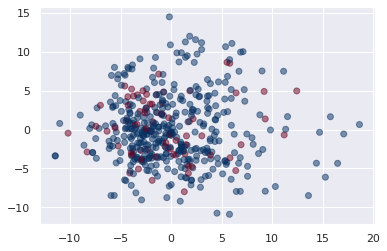

In [13]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)

## Visualizing Correlation of Features

With a heat map each feature can be compared to each other feature. With this vizualization we can prescribe some relation from feature to feature.

Let's start with the echonest rankings of artists and songs.

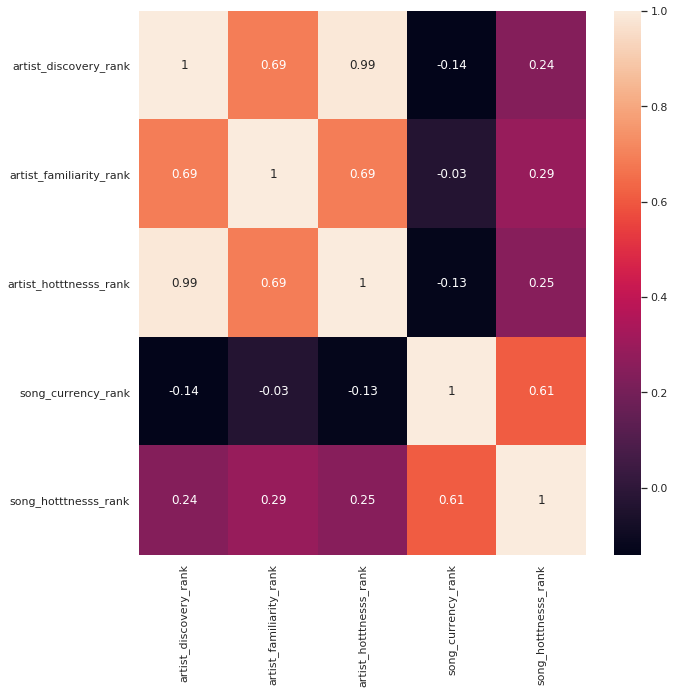

In [14]:
correlation_matrix = echonest['echonest', 'ranks'].corr().round(2)
plt.figure(figsize=(10,10))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

The upper right corner of the heat map contains high correlations. All three of features, Artist discovery, the hotttnesss and discorvery, are very similar. The artist hotttness and fimilarity have a .99 correlation. This is ecpected because the more familar the artist the more likley they are hot and have been discoverd.

There is also a strong correlation between the songs currency and hotttnesss. This is also explected for the same reason the artist rankings are similar.

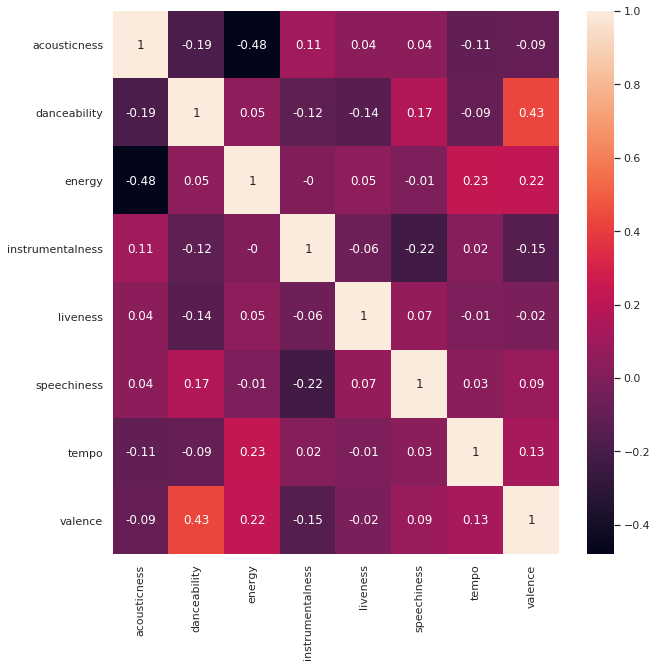

In [15]:
correlation_matrix = echonest['echonest', 'audio_features'].corr().round(2)
plt.figure(figsize=(10,10))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

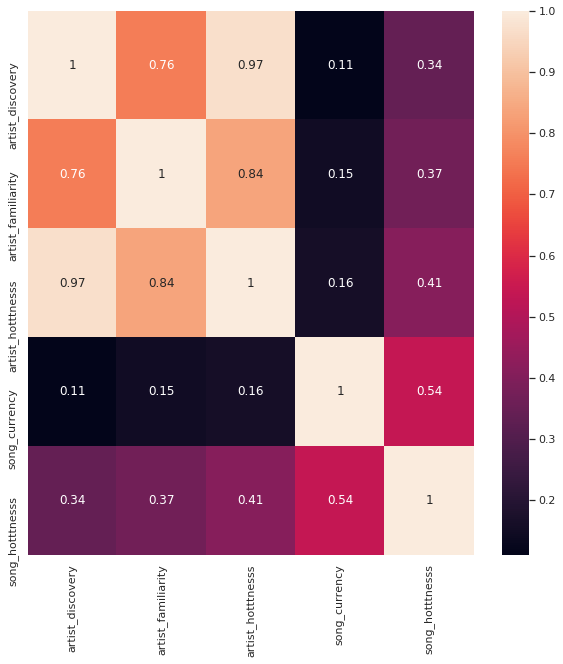

In [16]:
correlation_matrix = echonest['echonest', 'social_features'].corr().round(2)
plt.figure(figsize=(10,10))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

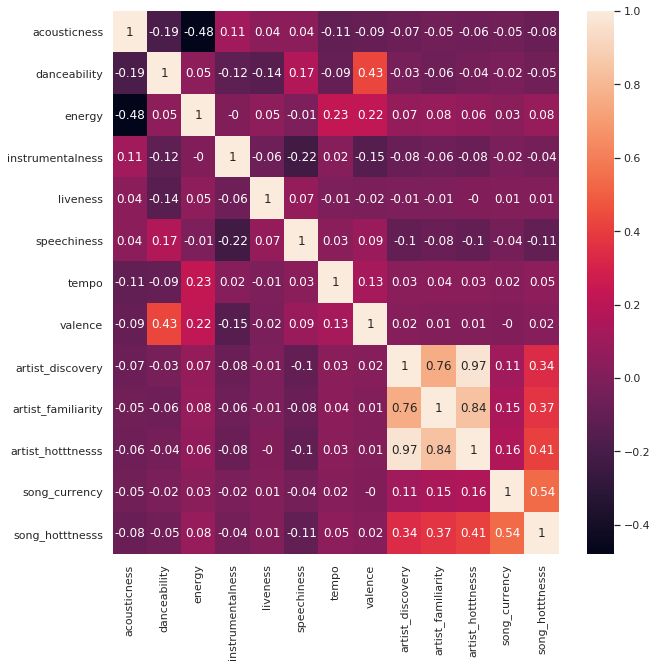

In [17]:
audio_social = echonest['echonest', 'audio_features'].join(echonest['echonest', 'social_features'])

correlation_matrix = audio_social.corr().round(2)
plt.figure(figsize=(10,10))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

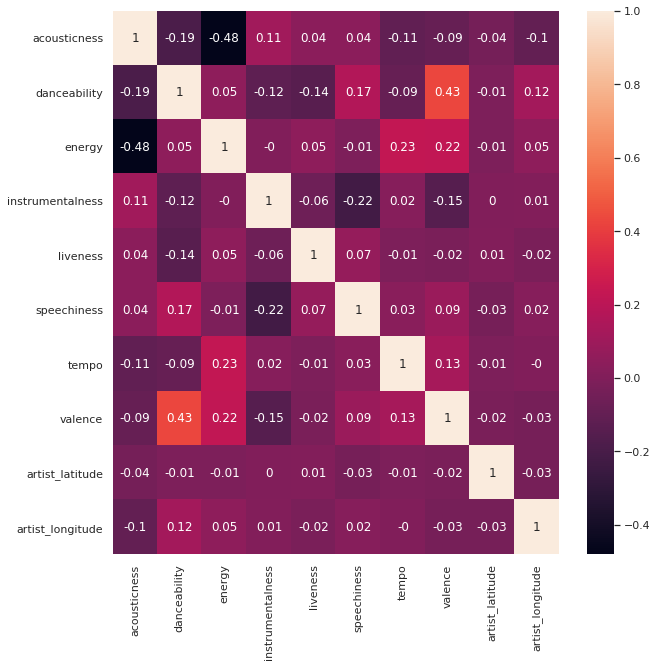

In [18]:
audio_social = echonest['echonest', 'audio_features'].join(echonest['echonest', 'metadata'])

correlation_matrix = audio_social.corr().round(2)
plt.figure(figsize=(10,10))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

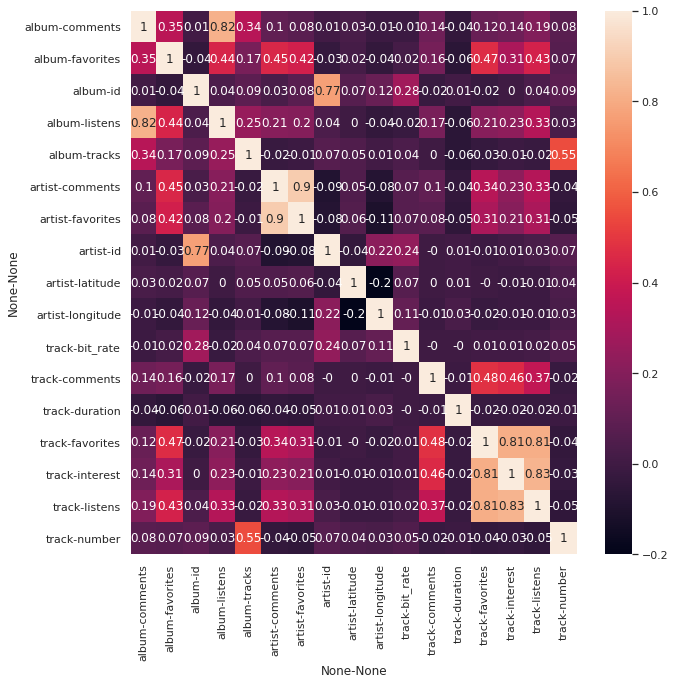

In [19]:
correlation_matrix = tracks.corr().round(2)
plt.figure(figsize=(10,10))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

Strongest Correlations:

* .83 track-interest and track-listens
* .82 album-listens and album-comments
* .81 track-favorites and track listens
* .81 track-favorites and track-interest
* .77 artist-id and album id

All of the strongest correlations are expected. The more listens means the more comments and the more favorites meanmore listens.

# Principle Component Analysis

Are all the features really that important to the target?

PCA allows the dataframe to drop to n number of primary components. The lower the number of components there are the faster the trainging and testing. However, with the loss of components is there is a loss in variance.

In [20]:
import sklearn as skl
import sklearn.utils, sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# subset of fma
small = tracks['set', 'subset'] <= 'small'

# store trainging, testing and validation splits
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'] == 'test'
val = tracks['set', 'split'] == 'validation'

# seperate features and targets
X = features.loc[small, 'mfcc']
y = tracks.loc[small, ('track', 'genre_top')]

# standardize the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
y = skl.preprocessing.LabelEncoder().fit_transform(y)


# stores dataframes
dfs = []

# stores variance
variance = []

# testing dimensions
dim = range(2, 141)

for d in dim:

    # create pca object of d-dimensions
    pca = PCA(n_components=d)

    # fit X and reduce dimensions
    principal_components = pca.fit_transform(X)
    
    # store sum variance
    variance.append(pca.explained_variance_[:].sum())

    # create and store header
    header = [('principle component ' + str(i)) for i in range(1, d+1)]

    # create and store dataframe
    df = pd.DataFrame(data = np.c_[principal_components, y], columns = header + ['genre'])
    dfs.append(df)

The graph shows the rate at which the variance decreases as the # of components decreases.

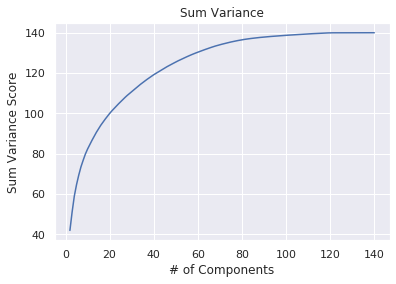

In [21]:
# plot variance
plt.figure()
plt.title('Sum Variance')
plt.xlabel('# of Components')
plt.ylabel('Sum Variance Score')
plt.plot(dim, list(variance))
plt.show()

<Figure size 432x288 with 0 Axes>

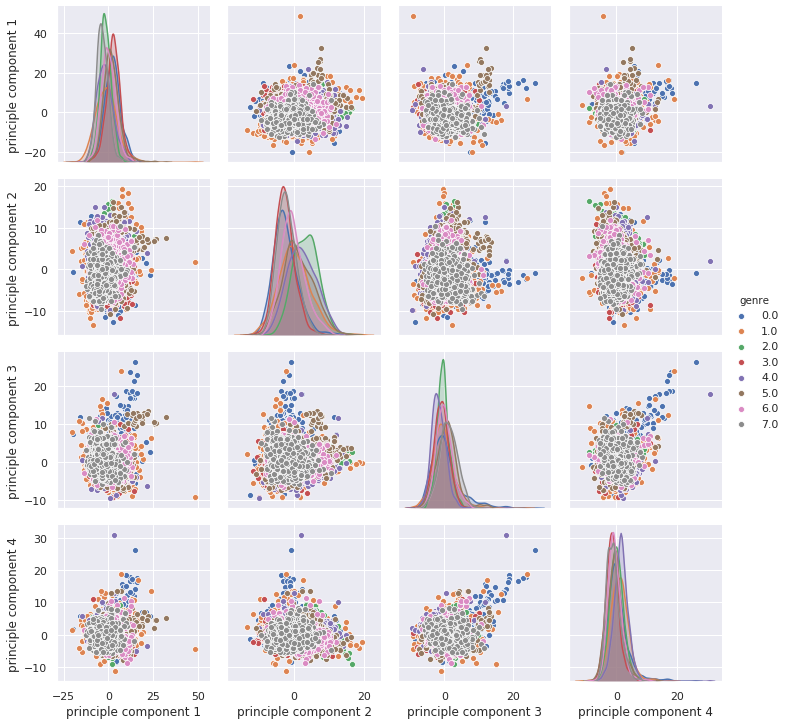

In [22]:
# plot 2 component dataframe
df = dfs[2]
plt.figure()
sns.pairplot(df, vars=df.columns[:-1], hue = 'genre')
plt.show()

# Splits

The data can now be split between the training, testing and validation sets. There are 6400 training samples, 800 testing.

In [23]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'


# split into training and testing
y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
y_val = tracks.loc[small & val, ('track', 'genre_top')]


X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']
X_val = features.loc[small & val, 'mfcc']


print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


## Training and Testing

There are 5 classifications for machine learning.
    * $k$-Nearest Neighbors
    * Decision Trees
    * Random Forest
    * Support Vector Machines

In [26]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 2.02407870e+00,  7.28341156e-01,  2.04241274e+00, ...,
        -5.21931263e-01, -8.24199676e-01, -7.80570294e-01],
       [ 1.40072301e-02, -3.89110770e-01, -2.80515927e-01, ...,
         2.49215243e-01,  1.43903422e-01,  7.42925519e-01],
       [-3.27751541e-02, -4.64044606e-01,  1.57717431e-01, ...,
         4.74054870e-02, -6.77014218e-03, -1.44250996e-01],
       ...,
       [-3.04122154e-01, -4.97753390e-01, -8.27489341e-06, ...,
         7.09121936e-01,  2.35810789e+00,  1.56903540e+00],
       [-2.59806394e-01, -2.07064389e-01,  1.37721511e-01, ...,
        -4.98516891e-01,  1.47795198e-01,  2.76447211e-01],
       [-2.95374053e-01, -7.25148255e-01,  3.32040621e-01, ...,
         4.31275266e-02, -1.65205994e-01,  8.37615946e-01]])

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# types of weights
weights = ["uniform", 'distance']

# store scores
k_scores_uniform = []
k_scores_distance = []

# optimized k(k, score)
opt_k = (1, 0)
k_list = range(23, 230, 2)

# loop through the different types of weights
for weight in weights:

    # loop through k_list
    for k in k_list:
        
        # create classifier with k-neighbors and weight
        knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
        
        # train
        knn.fit(X_train, y_train)
        
        # store test score
        score = accuracy_score(y_test, knn.predict(X_test))
        
        # store scores
        if weight == "uniform":
            k_scores_uniform.append(score)
        else:
            k_scores_distance.append(score)
        
    # check for a better depth
    if opt_k[1] <= score:
        opt_k = (k, score)

print("opt_k, opt_score", opt_k)

opt_k, opt_score (229, 0.3775)


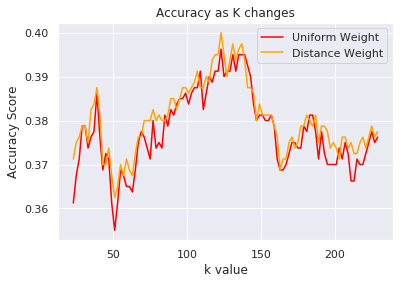

In [38]:
# plot k values
plt.figure()
plt.title('Accuracy as K changes')
plt.xlabel('k value')
plt.ylabel('Accuracy Score')
plt.plot(k_list, k_scores_uniform, color="red", label="Uniform Weight")
plt.plot(k_list, k_scores_distance, color="orange", label="Distance Weight")
plt.legend()
plt.show()

In [29]:
from sklearn import tree

# store scores
clf_scores = []

# optimized depth(depth, score)
opt_depth = (1, 0)

# test max_depth from 1-50
test_depth = range(1, 50)
for depth in test_depth:
    
    # create and store classifier
    clf = tree.DecisionTreeClassifier(max_depth = depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    # score = cross_val_score(clf, X, y, cv = cv, scoring = 'accuracy').mean()
    clf_scores.append(score)
    
    # check for a better depth
    if opt_depth[1] <= score:
        opt_depth = (depth, score)

print(opt_depth)

(6, 0.3225)


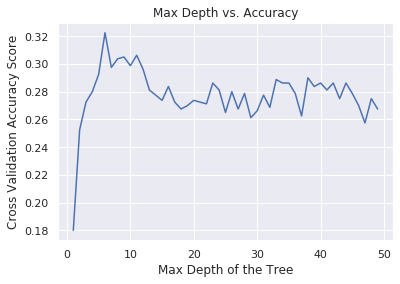

In [30]:
# plot 
plt.figure()
plt.title('Max Depth vs. Accuracy')
plt.xlabel('Max Depth of the Tree')
plt.ylabel('Cross Validation Accuracy Score')
plt.plot(test_depth, clf_scores)
plt.show()

In [31]:
from sklearn.ensemble import RandomForestClassifier

# store scores
rf_scores = []

# optimized depth(depth, score)
opt_depth = (0, 0)

# test max_depth from 9-20
test_depth = range(1, 30)
for depth in test_depth:

    # create and store classifier
    rf = RandomForestClassifier(max_depth = depth)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # create and store classifier and cross validation score
    # score = cross_val_score(rf, X, y, cv = cv, scoring = 'accuracy').mean()    
    rf_scores.append(score)
    
    # check for a better depth
    if opt_depth[1] <= score:
        opt_depth = (depth, score)

print(opt_depth)

(16, 0.445)


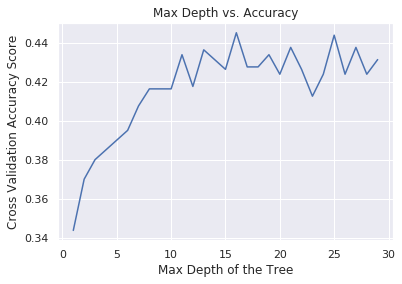

In [32]:
# plot 
plt.figure()
plt.title('Max Depth vs. Accuracy')
plt.xlabel('Max Depth of the Tree')
plt.ylabel('Cross Validation Accuracy Score')
plt.plot(test_depth, rf_scores)
plt.show()

In [33]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

# stores scores
lscores = []
pscores = []

# c testing range
C_list = [1, 150]
for C in C_list:

    # linear kernel training
    svc = svm.SVC(kernel='linear', C=C)
    lsvc = svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    lscores.append(accuracy_score(y_pred, y_test))

    # poly kernel training
    svc = svm.SVC(kernel='poly', C=C)
    psvc = svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    pscores.append(accuracy_score(y_pred, y_test))
    print(C)
    

print("linear accuracy: ", max(lscores))
print("poly accuracy: ", max(pscores))

1
150
linear accuracy:  0.41625
poly accuracy:  0.4175


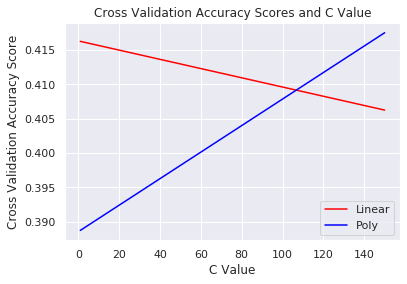

In [34]:
# plot 
plt.figure()
plt.title('Cross Validation Accuracy Scores and C Value')
plt.xlabel('C Value')
plt.ylabel('Cross Validation Accuracy Score')
plt.plot(C_list, lscores, color="red", label="Linear")
plt.plot(C_list, pscores, color="blue", label="Poly")
plt.legend()
plt.show()

## Neural Networks

Work In Progress.

In [35]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# create model
model = keras.Sequential([
    keras.layers.Dense(81, activation = 'relu'),
    keras.layers.Dense(9, activation = 'relu'),
    # output node
    keras.layers.Dense(11, activation = 'softmax')
])

# compile model
model.compile(optimizer = 'adam',
                 loss = "sparse_categorical_crossentropy",
             metrics = ['accuracy'])
# train model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: inputs=statistics  kurtosis                                                    \
number            01        02        03        04        05        06   
track_id                                                                 
82893      -0.322678 -0.225749 -0.463508 -0.599783 -0.446633 -0.167251   
120298     -0.244507  0.815384 -0.482310 -0.734507 -0.304753 -0.897235   
86443       0.694250  1.324258 -0.719596 -0.963193 -0.217288 -0.665807   
113259     -0.110515  1.542741 -0.454815 -0.273943  0.353453  0.013586   
14809      -0.346930 -0.673216 -0.435385  0.256652 -0.269930  0.312374   
...              ...       ...       ...       ...       ...       ...   
139804     -0.274724 -0.111670 -0.750511 -0.662530 -0.622769 -0.053864   
116465     -0.215517 -0.638770  0.285565  0.170505  0.327339  0.793767   
141284     -0.252399  0.520628 -0.581463 -0.172079 -0.425421  0.427668   
107434     -0.158014 -0.187017 -0.305418  0.088366 -0.069529  0.047450   
133546     -0.293733 -0.724333 -0.254057 -0.576307 -0.206909 -0.337933   

statistics                                          ...       std            \
number            07        08        09        10  ...        11        12   
track_id                                            ...                       
82893       0.614644 -0.384363 -0.115571  0.807387  ...  0.107508 -0.296122   
120298     -0.495918 -0.386373  0.804382  0.159714  ... -1.340535 -1.518315   
86443      -1.381830 -0.741573 -1.289413 -1.008838  ... -0.867992 -1.308444   
113259     -0.117485 -0.387422  0.282919  0.040542  ... -0.983012 -0.975258   
14809       0.075112 -0.391874 -0.374658 -0.107754  ... -0.401557 -0.237076   
...              ...       ...       ...       ...  ...       ...       ...   
139804     -0.277262 -0.064533  0.751017  0.527189  ...  1.143239  0.841806   
116465      0.032312  1.284556 -0.769978 -0.136541  ... -0.125256 -0.000239   
141284      2.012319  0.523510 -0.177512 -0.846292  ... -0.262251 -0.953617   
107434      0.339996  0.479709  0.541891  1.143144  ...  0.446032  1.048272   
133546     -0.681942 -0.837366 -0.833720 -0.485433  ...  2.038899  0.714089   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
82893      -0.305391 -0.450912 -0.540574 -0.388351 -0.402142 -0.274252   
120298     -1.357068 -1.230756 -1.086287 -0.945156 -0.490104 -0.695230   
86443      -1.514832 -1.334926 -1.162495 -1.200002 -0.950337 -1.114394   
113259     -0.767347 -0.972933 -0.905077 -0.747813 -0.782465 -0.822668   
14809      -0.101417 -0.684722 -0.472128 -0.545963 -0.855672 -0.520944   
...              ...       ...       ...       ...       ...       ...   
139804      0.374277  0.140904  0.224369  0.777108  0.781738  0.928346   
116465      0.247823  0.451799  0.140777  0.308974 -0.110955 -0.470464   
141284     -0.307057  0.409979  0.489158 -0.041897 -0.034021  0.058170   
107434      0.538756  0.609679  1.535224  1.331200  1.106972  1.029383   
133546     -0.129373  0.423223  0.486161  0.037816  0.453042  0.838239   

statistics                      
number            19        20  
track_id                        
82893      -0.127775 -0.277679  
120298     -0.607757 -0.930527  
86443      -0.797797 -0.935260  
113259     -0.381382 -0.405209  
14809      -0.980303 -0.791885  
...              ...       ...  
139804      1.287427  0.419564  
116465     -0.261796 -0.375715  
141284     -0.453969 -0.349335  
107434      1.426108  1.024046  
133546      1.237662  1.611350  

[6400 rows x 140 columns]

In [ ]:
# testing
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

## Recurrent Neural Networks (RNN)

Long-Short Term Memory

Work in progress.

In [ ]:
model = tf.keras.Sequential()

# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units and softmax activation.
model.add(layers.Dense(10, activation='softmax'))

# compile model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

# train and test
model.fit(x_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=batch_size,
          epochs=5)


https://www.tensorflow.org/tutorials/text/text_generation

# Comparing Accuracy of Classifers

[0.3775, 0.3225, 0.445, 0.41625, 0.4175]


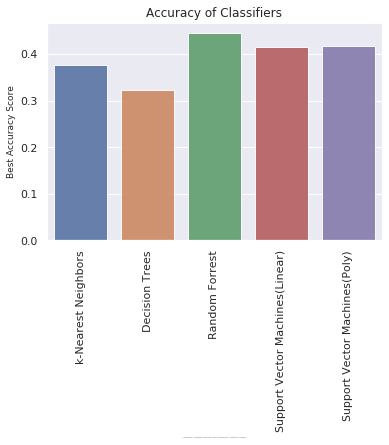

In [39]:
classifiers = ["k-Nearest Neighbors", "Decision Trees", "Random Forrest", "Support Vector Machines(Linear)", "Support Vector Machines(Poly)"]
values = [opt_k[1], max(clf_scores), max(rf_scores), max(lscores), max(pscores)]

print(values)
# plot bar chart
sns.set(style="darkgrid")
sns.barplot(classifiers, values, alpha=.9)
plt.title("Accuracy of Classifiers")
plt.xticks(rotation='vertical')
plt.xlabel(classifiers, fontsize=1)
plt.ylabel('Best Accuracy Score', fontsize=9)
plt.ylim(ymin=0)
plt.show()

## Conclusion

The highest accuracy of all the classifiers was 44.5%, achieved by the random forest classifier. This is a succeful accuracy for this classification due to the number of classification, 8 genres.

## Further Exploration

This project can be scaled up to implement the larger sets of data. We don't see the need to use the full dataset.
We can also fine fune the audio features of the training using librosa.
Other classifiers should be tested too. Neural Netwrks, specifically the long short term memory of recurrent neural networks.